In [21]:
import matplotlib.pyplot as plt
import networkx as nx

import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.data import HeteroData
from torch_geometric.utils import to_networkx

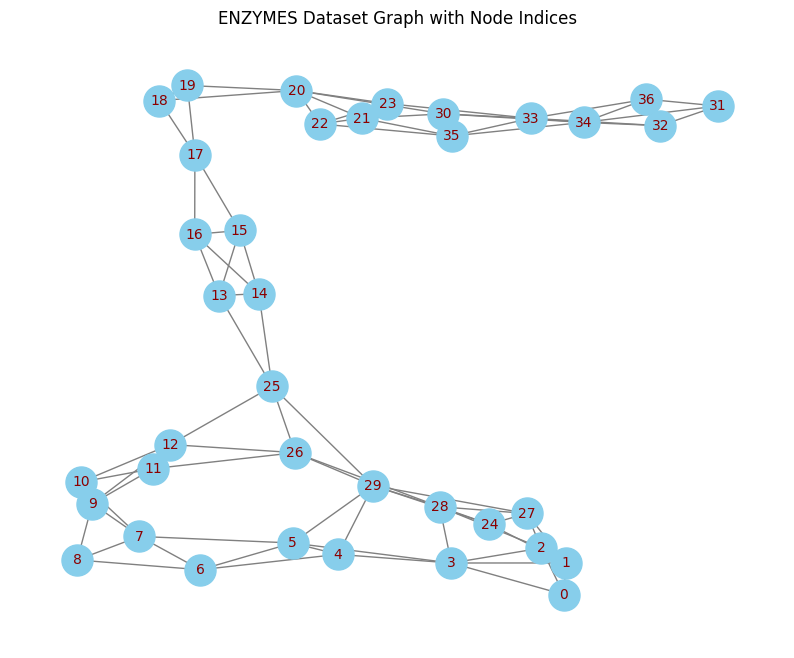

In [22]:
# Load the ENZYMES dataset
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

# Get the first graph from the dataset
data = dataset[0]

# Convert PyG graph to NetworkX graph
G = to_networkx(data, to_undirected=True)

# Set up the plot
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Positions for all nodes

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=1.0, edge_color='gray')

# Add node labels (indices)
nx.draw_networkx_labels(G, pos, labels={i: i for i in G.nodes()}, 
                        font_size=10, font_color='darkred')

# Remove axes
plt.axis('off')

# Show the graph
plt.title("ENZYMES Dataset Graph with Node Indices")
plt.show()

In [23]:
dataset[0]["edge_index"]

tensor([[ 0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12,
         12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16,
         16, 16, 17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 20, 20,
         21, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25,
         25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28,
         28, 28, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 32,
         32, 32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 35, 35,
         35, 35, 36, 36, 36, 36],
        [ 1,  2,  3,  0,  2,  3, 24, 27,  0,  1,  3, 27, 28,  0,  1,  2,  4,  5,
         28,  3,  5,  6, 29,  3,  4,  6,  7, 29,  4,  5,  7,  8,  5,  6,  8,  9,
         10,  6,  7,  9,  7,  8, 10, 11, 12,  7,  9, 11, 12,  9, 10, 12, 26

In [24]:
dataset[0]["x"]

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

In [25]:
dataset[0]["y"]

tensor([5])

In [73]:
def get_node_type_mapping(hom_data):
    """
    Dynamically identify node types from one-hot encoded features.
    
    e.g. [[0,0,1],      {0: [2]
          [1,0,0],  ->   1: [1]
          [0,1,0],       2: [0, 3]}
          [0,0,1]]
    """
    type_dict = {}
    for idx, x_row in enumerate(hom_data.x):
        type_idx = int(torch.argmax(x_row))
        if type_idx not in type_dict:
            type_dict[type_idx] = []
        type_dict[type_idx].append(idx)
    return type_dict

def create_mapping_dict(type_dict):
    """
    Create ID mapping dictionaries for all node types.

    Effectively, this resets node indecies for each node type in 
    the heterogeneous graph instead or maintaining the original 
    index from the homogeneous graph.    
    """
    return {t: {orig_idx: new_idx for new_idx, orig_idx in enumerate(nodes)} 
            for t, nodes in type_dict.items()}

def filter_and_remap_edges(hom_data, src_type_nodes, dst_type_nodes, 
                          src_map, dst_map, enforce_canonical):
    """Generalized edge filtering and index remapping."""
    src_tensor = torch.tensor(src_type_nodes)
    dst_tensor = torch.tensor(dst_type_nodes)

    # Create heterogeneous mask over homogeneous edge_index    
    mask = torch.isin(hom_data.edge_index[0], src_tensor) & torch.isin(hom_data.edge_index[1], dst_tensor)
    
    # Mask out edges other than source and destination edges
    filtered_edges = hom_data.edge_index[:, mask]
    
    # If there are no edges between source and destination nodes, create empty tensor for edge_index
    if filtered_edges.numel() == 0:
        return torch.empty((2, 0), dtype=torch.long)

    # Apply filter to get only edges between source and destination nodes
    src_indices = torch.tensor([src_map[orig.item()] for orig in filtered_edges[0]])
    dst_indices = torch.tensor([dst_map[orig.item()] for orig in filtered_edges[1]])

    # Stack to get edge_index for source and destination nodes
    edge_index = torch.stack([src_indices, dst_indices])
    
    # If you want to enforce canonical order, you can remove redundant edges for undirected graph
    if enforce_canonical:
        # For each edge, reorder so that the smaller index is first
        # We assume the ordering here is within the scope of the same relation
        reordered_src = torch.min(edge_index[0], edge_index[1])
        reordered_dst = torch.max(edge_index[0], edge_index[1])
        edge_index = torch.stack([reordered_src, reordered_dst])
        
        # Remove duplicates by taking unique columns
        edge_index = torch.unique(edge_index, dim=1)
    
    return edge_index

def convert_hom_to_het(hom_data, expected_types=[0, 1, 2], is_directed=True, enforce_canonical=False):
    """Convert any one-hot encoded homogeneous graph to heterogeneous format."""
    het_data = HeteroData()
    
    # Dynamically identify one-hot encoded node types
    type_dict = get_node_type_mapping(hom_data)

    # Create mappings and initialize nodes
    mapping_dict = create_mapping_dict(type_dict)
    
    # Add node types
    for t in expected_types:
        if t in type_dict:
            het_data[str(t)].x = torch.ones(len(type_dict[t]), 1)
        else:
            het_data[str(t)].x = torch.empty((0, 1))  # Placeholder if missing

    # Remove redundant edge mappings if undirected
    if is_directed:
        type_pairs = [(src, dst) for src in expected_types for dst in expected_types]
    else:
        type_pairs = [(src, dst) for i, src in enumerate(expected_types) for dst in expected_types[i:]]
    
    # Process all possible edge type combinations
    for src_type, dst_type in type_pairs:
        edge_type = (str(src_type), "to", str(dst_type))
        src_nodes = type_dict.get(src_type, [])
        dst_nodes = type_dict.get(dst_type, [])
        
        edge_index = filter_and_remap_edges(
            hom_data,
            src_nodes,
            dst_nodes,
            mapping_dict.get(src_type, {}),
            mapping_dict.get(dst_type, {}),
            enforce_canonical=enforce_canonical
        )
        het_data[edge_type].edge_index = edge_index

    # If label exists, add to graph
    if hasattr(hom_data, 'y'):
        het_data.y = hom_data.y
    
    return het_data


In [72]:
for i in (0, 10, 61, 115, 200):
    print(convert_hom_to_het(dataset[i], is_directed=False))

HeteroData(
  y=[1],
  0={ x=[24, 1] },
  1={ x=[13, 1] },
  2={ x=[0, 1] },
  (0, to, 0)={ edge_index=[2, 86] },
  (0, to, 1)={ edge_index=[2, 17] },
  (0, to, 2)={ edge_index=[2, 0] },
  (1, to, 1)={ edge_index=[2, 48] },
  (1, to, 2)={ edge_index=[2, 0] },
  (2, to, 2)={ edge_index=[2, 0] }
)
HeteroData(
  y=[1],
  0={ x=[0, 1] },
  1={ x=[0, 1] },
  2={ x=[4, 1] },
  (0, to, 0)={ edge_index=[2, 0] },
  (0, to, 1)={ edge_index=[2, 0] },
  (0, to, 2)={ edge_index=[2, 0] },
  (1, to, 1)={ edge_index=[2, 0] },
  (1, to, 2)={ edge_index=[2, 0] },
  (2, to, 2)={ edge_index=[2, 12] }
)
HeteroData(
  y=[1],
  0={ x=[10, 1] },
  1={ x=[18, 1] },
  2={ x=[11, 1] },
  (0, to, 0)={ edge_index=[2, 4] },
  (0, to, 1)={ edge_index=[2, 18] },
  (0, to, 2)={ edge_index=[2, 12] },
  (1, to, 1)={ edge_index=[2, 24] },
  (1, to, 2)={ edge_index=[2, 23] },
  (2, to, 2)={ edge_index=[2, 6] }
)
HeteroData(
  y=[1],
  0={ x=[11, 1] },
  1={ x=[11, 1] },
  2={ x=[20, 1] },
  (0, to, 0)={ edge_index=[2, 4] 